In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the folder to Colab
!unzip /content/drive/MyDrive/main.zip

Streaming output truncated to the last 5000 lines.
  inflating: main/i2d6oh-0.png       
  inflating: main/i2j3gfg-0.png      
  inflating: main/i2ld9y4-0.png      
  inflating: main/i2tc-0.png         
  inflating: main/i2ximgo-0.png      
  inflating: main/i33p04-0.png       
  inflating: main/i3498ffv-0.png     
  inflating: main/i3bq-0.png         
  inflating: main/i3cfm-0.png        
  inflating: main/i3dnm4ud-0.png     
  inflating: main/i3fdkmnz-0.png     
  inflating: main/i3hsnv-0.png       
  inflating: main/i3ijtc-0.png       
  inflating: main/i3jpjs-0.png       
  inflating: main/i3lamtg-0.png      
  inflating: main/i3na-0.png         
  inflating: main/i3reuje-0.png      
  inflating: main/i3s4k3w4-0.png     
  inflating: main/i3vv4b7-0.png      
  inflating: main/i3w8m4h-0.png      
  inflating: main/i3w9gzbb-0.png     
  inflating: main/i40a6-0.png        
  inflating: main/i41wb-0.png        
  inflating: main/i45h2-0.png        
  inflating: main/i4cnotad-0.png     

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


cuda


In [46]:
class CaptchaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        if self.transform:
            image = self.transform(image)
        return image


# Define your transformations
transform = transforms.Compose([
    transforms.Resize((80, 80)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Specify the directory containing captcha images
image_dir = "main"  # Replace with the path to your 'main' folder

# Create the dataset and dataloader
captcha_dataset = CaptchaDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(captcha_dataset, batch_size=128, shuffle=True, num_workers=2)


In [38]:
class Generator(nn.Module):
    def __init__(self, noise_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, img_channels * 80 * 80),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 3, 80, 80)  # Assuming RGB captcha of size 64x64

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 80, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(80, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 20 * 20, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [48]:
# Hyperparameters
noise_dim = 100
img_channels = 3
lr = 0.0002
batch_size = 128
epochs = 20

# Initialize models
generator = Generator(noise_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [49]:
# Training loop
for epoch in range(epochs):
    for real_images in dataloader:
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        # Train with real images
        outputs = discriminator(real_images)
        loss_real = criterion(outputs, labels_real)

        # Train with fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        loss_fake = criterion(outputs, labels_fake)

        # Update Discriminator
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, labels_real)  # Generator wants the Discriminator to classify fake as real
        g_loss.backward()
        optimizer_g.step()
    if epoch % 1 == 0:
        print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")


Epoch [0/20] | D Loss: 0.32308220863342285 | G Loss: 5.653717041015625
Epoch [1/20] | D Loss: 1.3005540370941162 | G Loss: 4.479151725769043
Epoch [2/20] | D Loss: 0.9197280406951904 | G Loss: 5.75601863861084
Epoch [3/20] | D Loss: 1.109863519668579 | G Loss: 4.288195610046387
Epoch [4/20] | D Loss: 1.0468111038208008 | G Loss: 4.571016311645508
Epoch [5/20] | D Loss: 0.8598193526268005 | G Loss: 5.209782600402832
Epoch [6/20] | D Loss: 0.8821431398391724 | G Loss: 7.793943405151367
Epoch [7/20] | D Loss: 1.0365383625030518 | G Loss: 3.7698869705200195
Epoch [8/20] | D Loss: 0.7550084590911865 | G Loss: 6.406722068786621
Epoch [9/20] | D Loss: 0.9032182693481445 | G Loss: 3.8788647651672363
Epoch [10/20] | D Loss: 0.4884778559207916 | G Loss: 2.3024752140045166
Epoch [11/20] | D Loss: 0.87697434425354 | G Loss: 4.330874919891357
Epoch [12/20] | D Loss: 1.2723361253738403 | G Loss: 3.3764874935150146
Epoch [13/20] | D Loss: 0.9339690804481506 | G Loss: 1.2364436388015747
Epoch [14/20] 

torch.Size([3, 80, 80])


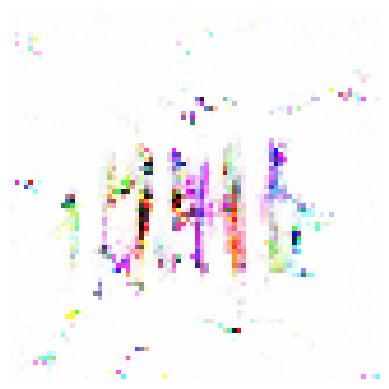

In [68]:
def generate_captcha(generator, noise_dim):
    generator.eval()  # Set generator to evaluation mode
    noise = torch.randn(1, noise_dim).to(device)  # Generate noise with batch size of 1
    with torch.no_grad():
        captcha = generator(noise).cpu().squeeze().detach()
    generator.train()  # Switch back to training mode if needed
    print(captcha.shape)
    return captcha.reshape((3, 80, 80)) # TODO: reshape to proper size

# Display the captcha

captcha_image = generate_captcha(generator, noise_dim)
plt.imshow(captcha_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Rescale for display
plt.axis('off')
plt.show()
